In [87]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16, ResNet50, vgg16, resnet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Resizing
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
import keras.backend as K
import math
import os
import cv2
from enum import Enum

# Metrics



In [88]:
# Normalized Scanpath Salience
def nss(y_true, y_pred):
  max_y_pred = tf.math.reduce_max(y_pred)
  y_pred /= max_y_pred

  y_mean = tf.math.reduce_mean(y_pred)
  y_mean = tf.convert_to_tensor(y_mean)

  y_std = tf.math.reduce_std(y_pred)
  y_std = tf.convert_to_tensor(y_std)

  y_pred = (y_pred - y_mean) / y_std
  den = tf.math.reduce_sum(tf.math.multiply(y_true, y_pred))
  nom = tf.math.reduce_sum(y_true)

  nss_out = den/nom

  return nss_out

In [89]:
# Corelation Coefficent
def cc(y_true, y_pred):
  max_y_pred = tf.math.reduce_max(y_pred)
  y_pred /= max_y_pred

  y_pred_std = tf.math.reduce_std(y_pred)
  y__pred_std = tf.convert_to_tensor(y_pred_std)

  y_true_std = tf.math.reduce_std(y_pred)
  y_true_std = tf.convert_to_tensor(y_true_std)

  return tfp.stats.covariance(y_true, y_pred) / (y_pred_std * y_true_std)

In [90]:
# Similarity
def sim(y_true, y_pred):
  y_true /= tf.math.reduce_sum(y_true)
  y_pred /= tf.math.reduce_sum(y_pred)

  hists = tf.convert_to_tensor([y_true, y_pred])
  hist = tf.math.reduce_min(hists, axis=0)

  return tf.math.reduce_sum(hist)

In [91]:
# KLDivergence with normlaized output
def kl_divergence(y_true, y_pred):
  y_true /= tf.math.reduce_sum(y_true)
  y_pred /= tf.math.reduce_sum(y_pred)

  return tf.keras.metrics.kl_divergence(y_true, y_pred)

# Model loading


In [92]:
# saclicon parameters

SAL_MAP_WIDTH = 20
SAL_MAP_HEIGHT = 15

In [93]:
MODELS_PATH='/content/drive/MyDrive/'

# Possible feature extraction networks
class DNN(Enum):
  VGG16 = 'vgg16'
  RESNET50 = 'resnet50'

# Salicon model class
class SimpleSaliency(Model):
    def __init__(self, name='saliency', dnn = DNN.VGG16, load_weights = True, **kwargs):
      self.dnn = dnn
      super().__init__(name=name, **kwargs)
      self.build((None, 480, 640, 3)) # SALICON dataset shape
      if load_weights:
        if len(MODELS_PATH) == 0:
          raise Exception('Set value for global variable MODELS_PATH')

        if self.dnn == DNN.VGG16: # load weights
          self.load_weights(f'{MODELS_PATH}/salicon-vgg16/simple_saliency_vgg16.tf')
        else:
          self.load_weights(f'{MODELS_PATH}/salicon-resnet50/simple_saliency_resnet50.tf')
      self.preprocess_input = vgg16.preprocess_input if dnn == DNN.VGG16 else  resnet50.preprocess_input

    def __build_vgg16(self, input_shape, stream_type):
      vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
      for layer in vgg.layers:
        layer._name = layer._name + '_' + stream_type
        layer.trainable = True
      vgg.trainable = True

      return vgg

    def __build_resnet50(self, input_shape, stream_type):
      resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
      for layer in resnet50.layers:
        layer._name = layer._name + '_' + stream_type
        layer.trainable = True
      resnet50.trainable = True

      return resnet50

    def __build_dnn(self, input_shape, stream_type):
      if self.dnn == DNN.VGG16:
        return self.__build_vgg16(input_shape, stream_type)
      else:
        return self.__build_resnet50(input_shape, stream_type)

    def build(self, input_shape):
      H, W = input_shape[1:3]
      self.fine = self.__build_dnn(input_shape=(H, W, 3), stream_type='fine')
      self.downscale_input = MaxPooling2D(pool_size=(2, 2))
      self.coarse = self.__build_dnn(input_shape=(H // 2, W // 2, 3), stream_type='coarse')
      self.saliency_map_layer = Conv2D(
        1, (1, 1),
        name='saliency_map',
        trainable=True,
        activation='sigmoid',
        kernel_initializer=initializers.Zeros(),
        bias_initializer=initializers.Zeros()
      )
      super().build(input_shape)

    def call(self, input):
      # create two streams separately
      fine_output = self.fine(input)

      downscaled_input = self.downscale_input(input)
      coarse_output = self.coarse(downscaled_input)

      # add interpolation layer to the coarse stream
      H, W = self.fine.output.shape[1:3]

      interp_layer = Resizing(H, W, interpolation='nearest')(coarse_output)

      concat_layer = concatenate([fine_output, interp_layer], axis=-1)

      return self.saliency_map_layer(concat_layer)

    def compute_saliency(self, img_path=None, img=None):
      image = None
      if img_path:
        image = cv2.imread(img_path)
      else:
        image = img
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (640, 480))
      image = self.preprocess_input(image)
      h, w = image.shape[:2]

      smap = np.squeeze(self.predict(np.expand_dims(image, axis=0), batch_size=1, verbose=0))

      smap = (smap - np.min(smap))/((np.max(smap)-np.min(smap)))
      smap = cv2.resize(smap, (w, h), interpolation=cv2.INTER_CUBIC)
      smap = cv2.GaussianBlur(smap, (75, 75), 25, cv2.BORDER_DEFAULT)

      return smap

In [94]:
salicon = SimpleSaliency(dnn=DNN.RESNET50)
salicon.summary()

Model: "saliency"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 saliency_map (Conv2D)       multiple                  4097      
                                                                 
Total params: 47179521 (179.98 MB)
Trainable params: 47073281 (179.57 MB)
Non-trainable params: 106240 (415.00 KB)
_________________________________________________________________


In [95]:
salicon_vgg = SimpleSaliency(dnn=DNN.VGG16)
salicon_vgg.summary()

Model: "saliency"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 20, 512)       14714688  
                                                                 
 max_pooling2d_8 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
 saliency_map (Conv2D)       multiple                  1025      
                                                                 
Total params: 29430401 (112.27 MB)
Trainable params: 29430401 (112.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
# ML-Net sttings
BATCH = 10

IMG_HEIGHT = 480
IMG_WIDTH = 640

ML_MAP_HEIGHT = int(math.ceil(IMG_HEIGHT / 8))
ML_MAP_WIDTH = int(math.ceil(IMG_WIDTH / 8))

EPOCHS = 20

TRAIN_SIZE = 10000
VAL_SIZE = 5000

In [97]:
# ML-Net custom layer

class EltWiseProduct(Layer):
    def __init__(self, downsampling_factor=10, init='glorot_uniform', activation='linear',
                 weights=None, W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.downsampling_factor = downsampling_factor
        self.init = initializers.get(init)
        self.activation = activation
        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.input_dim = input_dim

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        self.input_spec = InputSpec(ndim=4)
        super(EltWiseProduct, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_shape = (ML_MAP_HEIGHT, ML_MAP_WIDTH, 1)   # Adjusted weight shape for broadcasting
        self.W = self.add_weight(shape=self.W_shape,
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None,) + input_shape[1:])
        self.built = True

    def call(self, x, mask=None):
        output = x * tf.expand_dims(1 + self.W, 0)  # Broadcasting across the channel dimension
        #output = K.resize_images(output, self.downsampling_factor, 1, 'channels_last')
        # output = tf.image.resize(output, (MAP_HEIGHT, MAP_WIDTH))
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'downsampling_factor': self.downsampling_factor,
            'init': initializers.serialize(self.init),
            'activation': self.activation,
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'input_dim': self.input_dim
        }
        base_config = super(EltWiseProduct, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [98]:
# ML-Net custom loss function
def mlnet_loss(y_true, y_pred):
  max_y = K.max(K.max(y_pred, axis=1), axis=1)  # Adjust axis values
  max_y = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(max_y, axis=-1), IMG_HEIGHT, axis=-1)), IMG_WIDTH, axis=-1)
  return K.mean(K.square((y_pred / max_y) - y_true) / (1.1 - y_true))

In [99]:
# read ML-Net
ml_net = tf.keras.models.load_model('/content/drive/MyDrive/salicon/mlnet-bigger_prior-29-0.03.hdf5', custom_objects={"EltWiseProduct":EltWiseProduct, 'loss': mlnet_loss})
ml_net.summary()

Model: "mlnet-vgg19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 120, 160, 256)        2325568   ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 60, 80, 256)          0         ['sequential[0][0]']          
 D)                                                                                               
                                                                                                  
 sequential_1 (Sequential)   (None, None, None, 512)      8259584   ['max_pooling2d[0][0

# Test data preparation



In [100]:
VAL_IMG_PATH = "/content/drive/MyDrive/salicon/images/val"
TRAIN_MAP_PATH = "/content/drive/MyDrive/salicon/maps/train"
VAL_MAP_PATH = "/content/drive/MyDrive/salicon/maps/val"

In [101]:
# ml-net data generator
class MLNetDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, size):
      datas = [f for f in os.listdir(data)]
      labeles = [f for f in os.listdir(labels)]
      datas.sort()
      labeles.sort()
      self.images = [data + "/" + f for f in datas[:size]]
      self.maps = [labels + "/" + f for f in labeles[:size]]

      self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        x = []
        y = []
        for f in self.images[start:end]:
          image = cv2.imread(f)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = tf.keras.applications.vgg19.preprocess_input(image)
          x.append(image)

        for f in self.maps[start:end]:
          image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
          y.append(image.astype('float32') / 255)

        # Implement any data preprocessing here if needed
        return np.array(x), np.array(y)


# salicon data generator
class SaliencyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, max_size = 1000, dnn = DNN.VGG16):
      self.batch_size = batch_size
      self.images = [data + "/" + f for f in sorted(os.listdir(data))[:max_size]]
      self.maps = [labels + "/" + f for f in sorted(os.listdir(labels))[:max_size]]
      self.preprocess_input = vgg16.preprocess_input if dnn == DNN.VGG16 else  resnet50.preprocess_input

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        x = []
        y = []
        for f in self.images[start:end]:
          image = cv2.imread(f)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = self.preprocess_input(image)

          x.append(image)

        for f in self.maps[start:end]:
          image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (SAL_MAP_WIDTH, SAL_MAP_HEIGHT), interpolation=cv2.INTER_NEAREST)
          y.append(image.astype('float32') / 255)

        return np.array(x), np.array(y)

## Prepare data generators

In [102]:
salicon_test_generator = SaliencyDataGenerator(VAL_IMG_PATH, VAL_MAP_PATH, BATCH, 5000, DNN.RESNET50)

In [103]:
mlnet_test_generator = MLNetDataGenerator(VAL_IMG_PATH, VAL_MAP_PATH, BATCH, 5000)

In [104]:
# prepare salicon
salicon_sgd = tf.keras.optimizers.experimental.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
salicon.compile(optimizer=salicon_sgd, loss="binary_crossentropy", metrics=[nss, cc, sim, kl_divergence, tf.keras.metrics.AUC()])

In [105]:
salicon_vgg.compile(optimizer=salicon_sgd, loss="binary_crossentropy", metrics=[nss, cc, sim, kl_divergence, tf.keras.metrics.AUC()])

In [106]:
# prepare ml-net
mlnet_sgd = tf.keras.optimizers.experimental.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=0.0005, nesterov=True)
ml_net.compile(optimizer=mlnet_sgd, loss=mlnet_loss, metrics=[nss, cc, sim, kl_divergence, tf.keras.metrics.AUC()])

# Testing

In [107]:
# test first model
salicon.evaluate(salicon_test_generator)

KeyboardInterrupt: ignored

In [ ]:
salicon_vgg.evaluate(salicon_test_generator)

In [ ]:
# test second model
ml_net.evaluate(mlnet_test_generator)

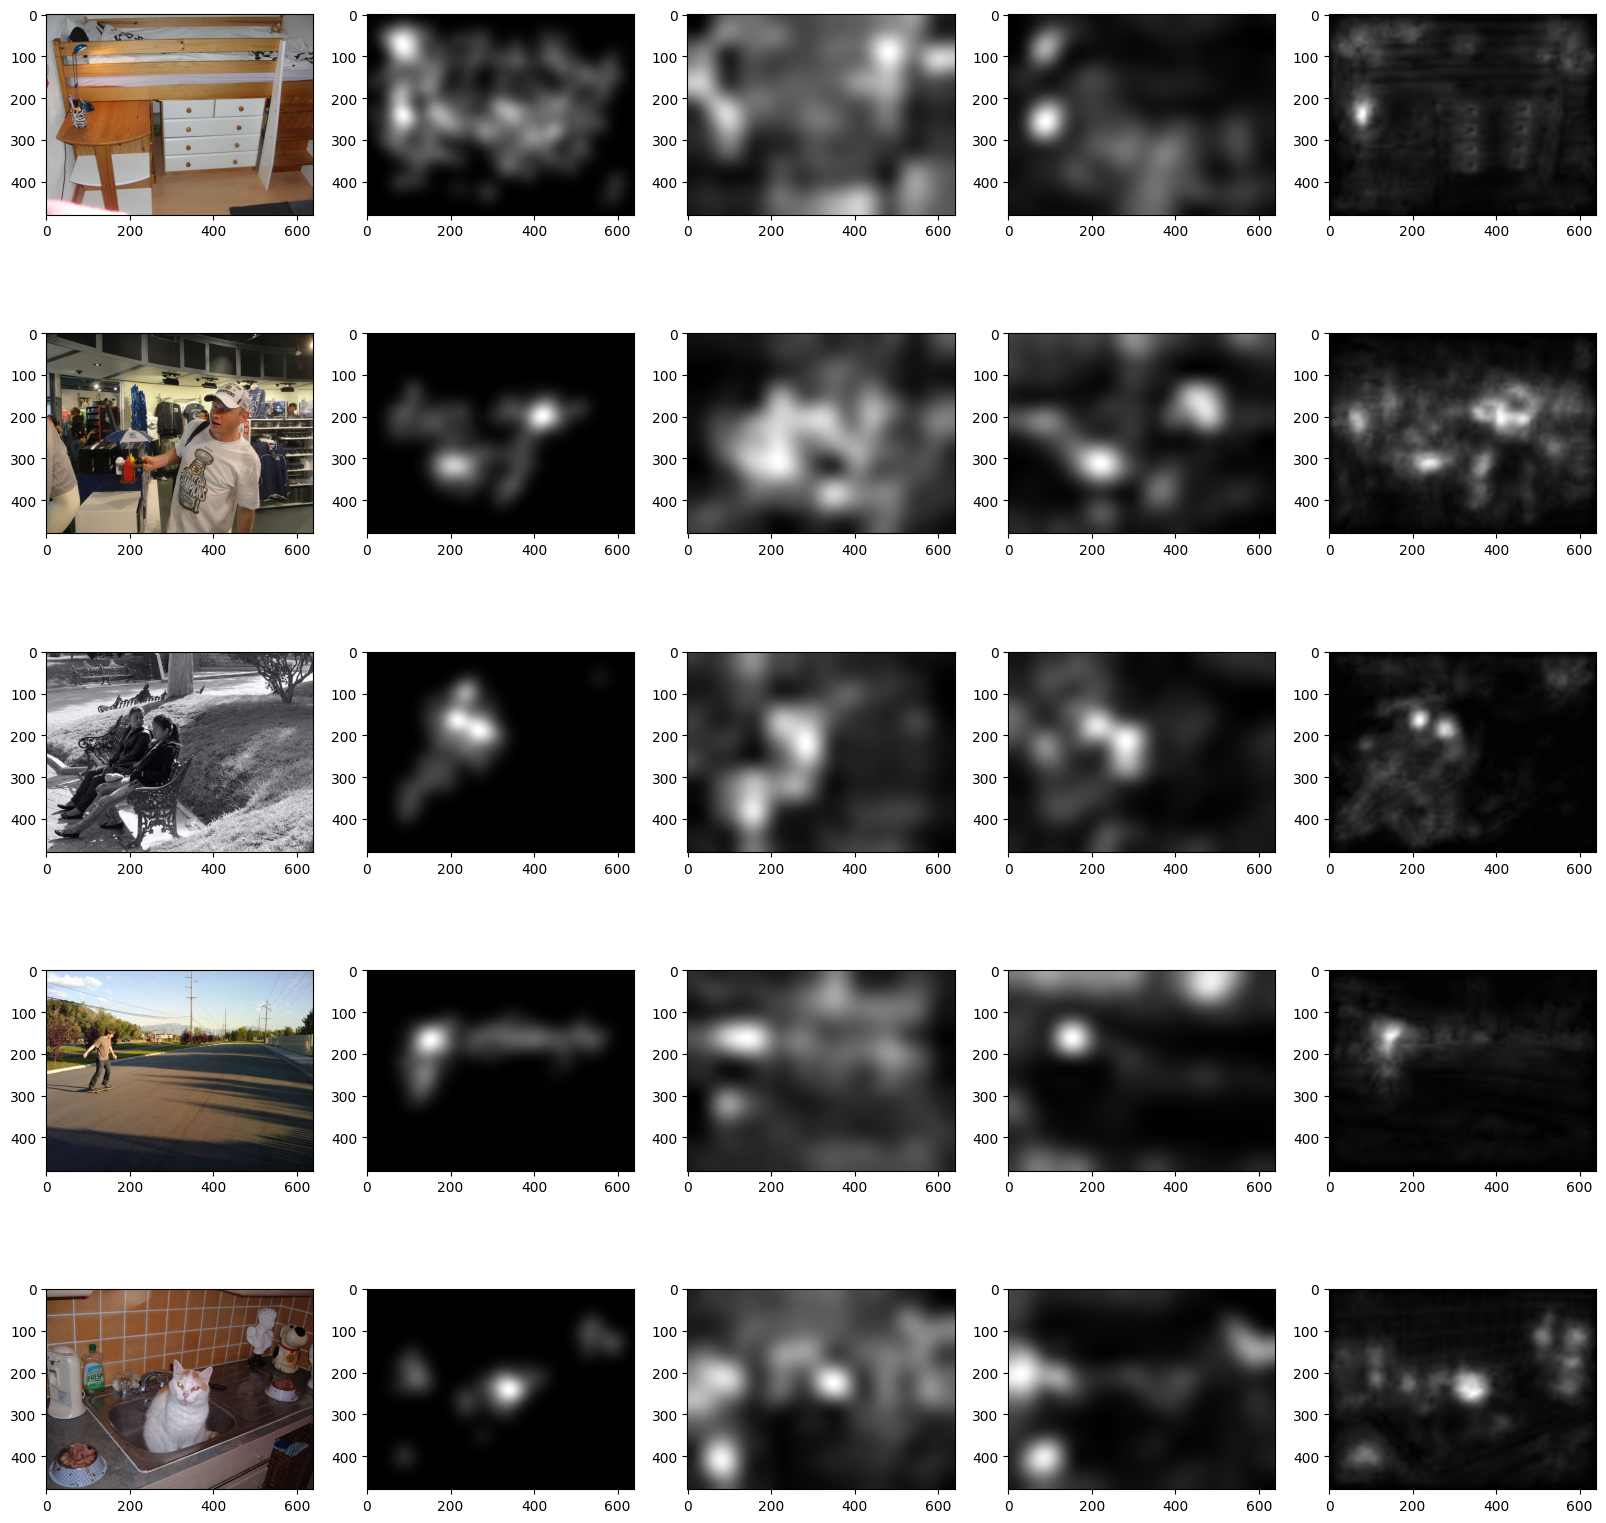

In [117]:
f, ax = plt.subplots(5, 5)
f.set_figwidth(20)
f.set_figheight(20)

images_list = sorted(os.listdir(VAL_IMG_PATH))
map_list = sorted(os.listdir(VAL_MAP_PATH))

for i in range(5):
  image = cv2.imread(VAL_IMG_PATH + '/' + images_list[i*1000])
  pred_vgg16 = salicon_vgg.compute_saliency(img=image)
  pred_res = salicon.compute_saliency(img=image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  map = cv2.imread(VAL_MAP_PATH + '/' + map_list[i*1000], cv2.IMREAD_GRAYSCALE)
  img_vgg19 = tf.keras.applications.vgg19.preprocess_input(image)
  ml_pred = ml_net(img_vgg19.reshape(1,480,640,3))
  ax[i][0].imshow(image)
  ax[i][1].imshow(map, cmap="gray")
  ax[i][2].imshow(pred_vgg16, cmap="gray")
  ax[i][3].imshow(pred_res, cmap="gray")
  ax[i][4].imshow(ml_pred.numpy().reshape(480,640,1), cmap='gray')

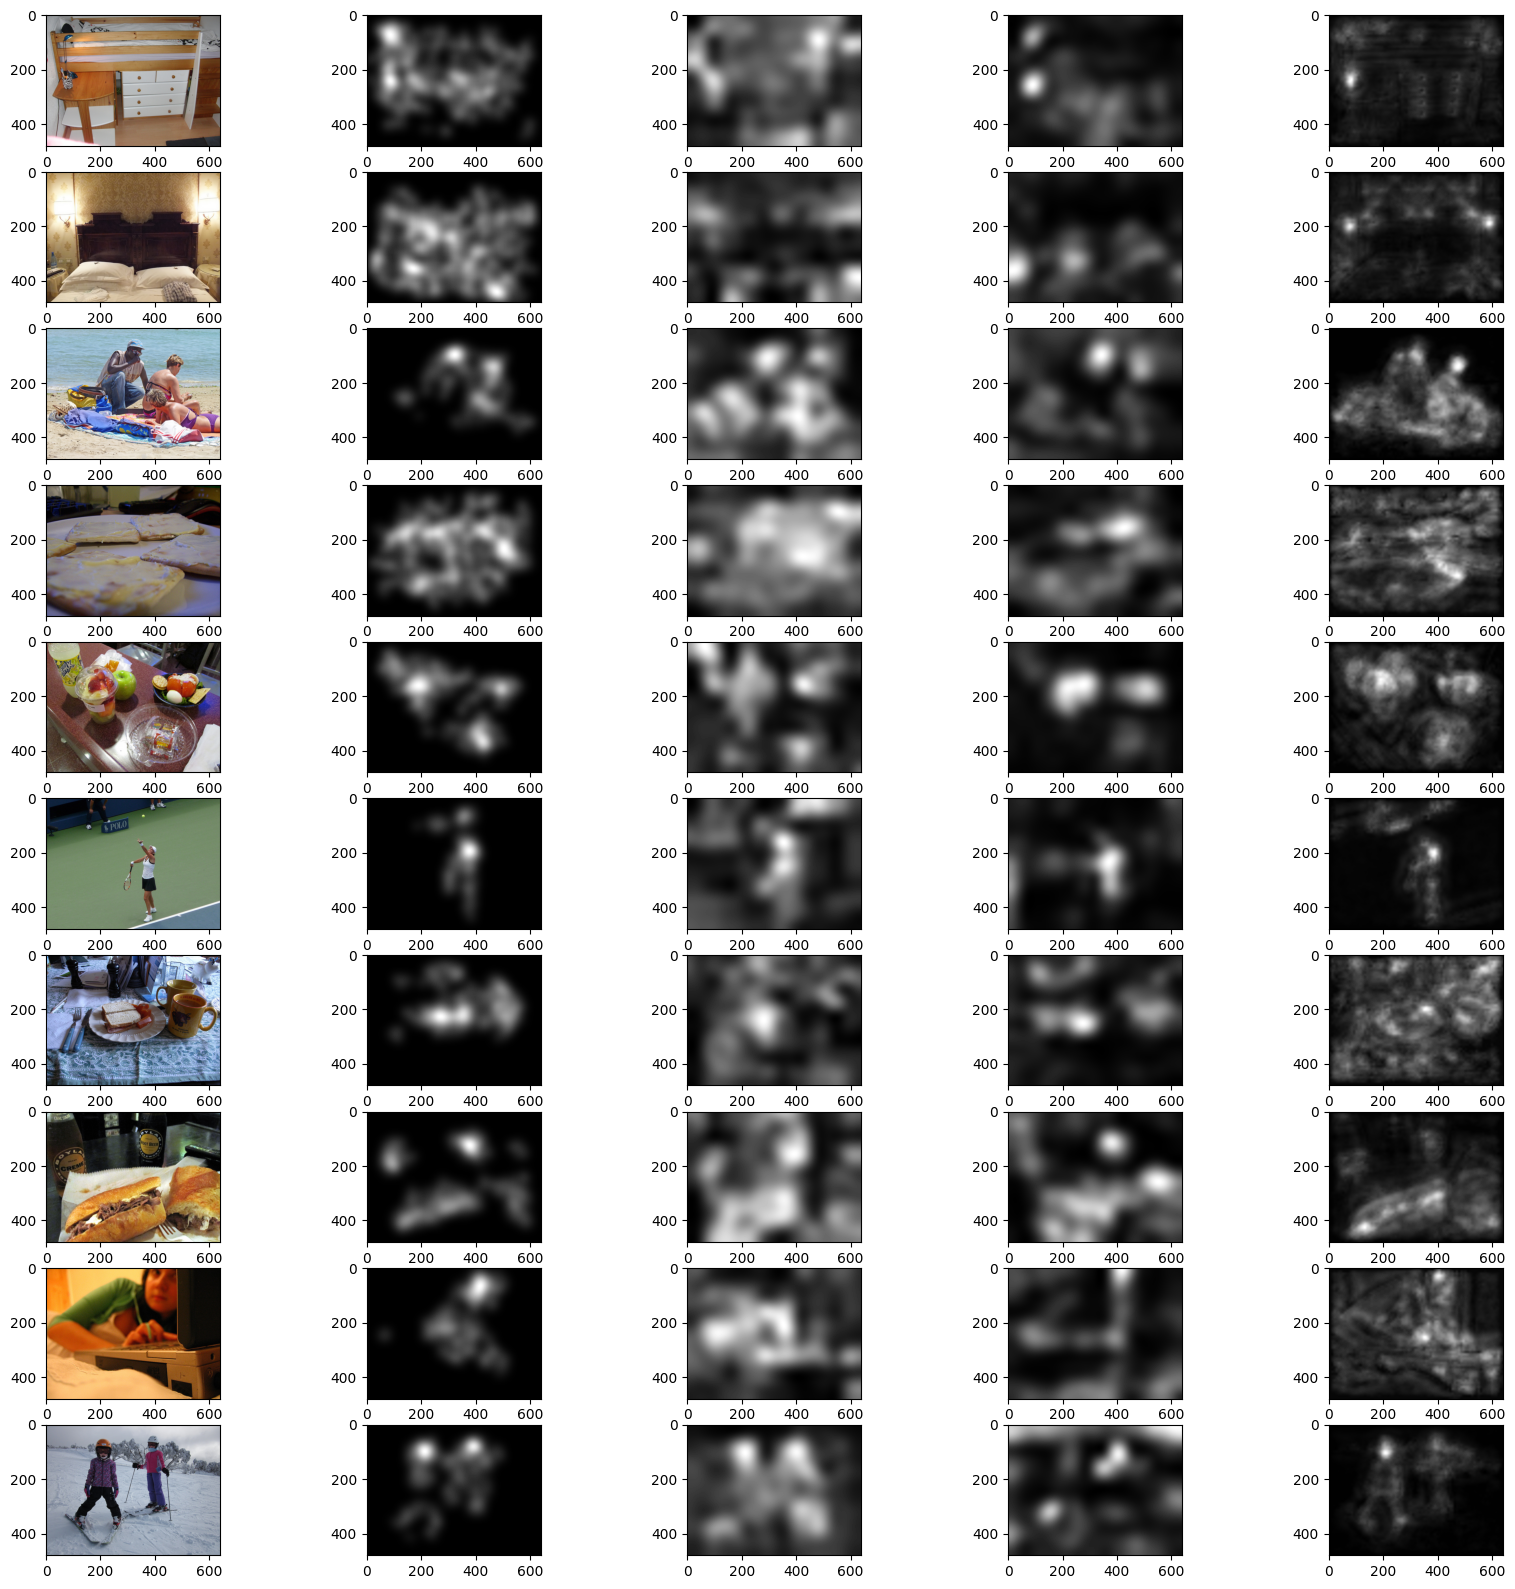

In [120]:
from random import choices

f, ax = plt.subplots(10, 5)
f.set_figwidth(20)
f.set_figheight(20)

for i in range(10):
  image = cv2.imread(VAL_IMG_PATH + '/' + images_list[i*69])
  pred_vgg16 = salicon_vgg.compute_saliency(img=image)
  pred_res = salicon.compute_saliency(img=image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  map = cv2.imread(VAL_MAP_PATH + '/' + map_list[i*69], cv2.IMREAD_GRAYSCALE)
  img_vgg19 = tf.keras.applications.vgg19.preprocess_input(image)
  ml_pred = ml_net(img_vgg19.reshape(1,480,640,3))
  ax[i][0].imshow(image)
  ax[i][1].imshow(map, cmap="gray")
  ax[i][2].imshow(pred_vgg16, cmap="gray")
  ax[i][3].imshow(pred_res, cmap="gray")
  ax[i][4].imshow(ml_pred.numpy().reshape(480,640,1), cmap='gray')